# **Import Libraries**

In [1]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# **Read The Data**

In [2]:
df = pd.read_csv("/kaggle/input/zcr-rmse/features_final.csv")

# **Fill NaN Values With Zeros**

In [3]:
df.fillna(0, inplace = True)

# **Split The Data into Train & Validation & Test**

In [4]:
X = df.drop(columns=['labels']).values
y = df['labels'].values

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, train_size = .7, random_state = 42, shuffle = True, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, train_size = .95, random_state = 42, shuffle = True, stratify = y_temp)

# **Normalize Data**

In [6]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# **Convert DataFrame Into Tensors and Add The Depth Channel**

In [7]:
X_train = torch.tensor(X_train).float().unsqueeze(1)
X_test  = torch.tensor(X_test).float().unsqueeze(1)
X_val   = torch.tensor(X_val).float().unsqueeze(1)

# **Apply One Hot Encodding and Convert the labels to Tensors**

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
y_val = enc.transform(y_val)

In [9]:
y_train = torch.tensor(y_train.toarray(), dtype=torch.float32)
y_test  = torch.tensor(y_test.toarray(), dtype=torch.float32)
y_val   = torch.tensor(y_val.toarray(), dtype=torch.float32)

# **Create DataLoaders**

In [10]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size = 64, shuffle = True)
test_loader  = DataLoader(TensorDataset(X_test, y_test),   batch_size = 64, shuffle = False)
val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size = 64, shuffle = False)

# **Create Model Architecture**

In [11]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(512, 512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(512, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7, 512), 
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x

# **Create Model And Define Loss Function**

In [12]:
model = CNN1D()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  

# **Training Loop**

In [13]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_combination = ()

def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        true_labels = torch.argmax(y_batch, dim=1)
        correct_preds += (predicted == true_labels).sum().item()
        total_preds += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds
    return train_loss, train_accuracy


def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

            _, predicted = torch.max(output, 1)
            true_labels = torch.argmax(y_batch, dim=1)
            correct_preds += (predicted == true_labels).sum().item()
            total_preds += y_batch.size(0)

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_preds / total_preds
    return val_loss, val_accuracy


def train(model, train_loader, val_loader, optimizer, criterion, combo_best_acc, num_epochs=10, checkpoint_path='best_model.pt'):
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if val_accuracy > combo_best_acc:
            combo_best_acc = val_accuracy
            torch.save(model.state_dict(), checkpoint_path)

    return combo_best_acc

# **Hyper Parameters Tuning**

In [14]:
def plot_metrics(title=""):
    plt.figure(figsize=(12, 5))

    plt.suptitle(title, fontsize=14, y=1.05)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Training with Optimizer: Adam, Learning Rate: 0.01


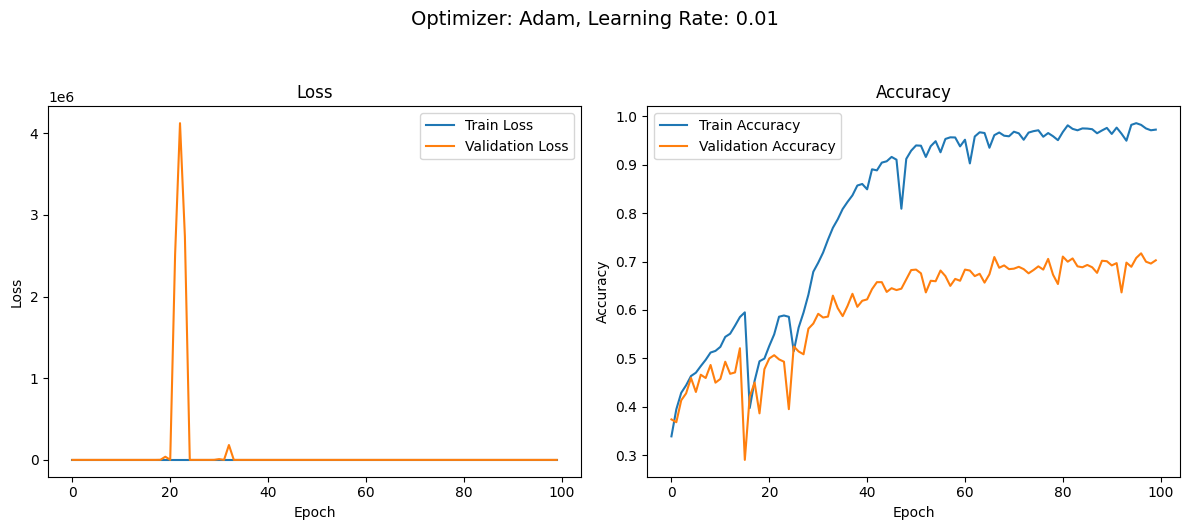


Training with Optimizer: Adam, Learning Rate: 0.001


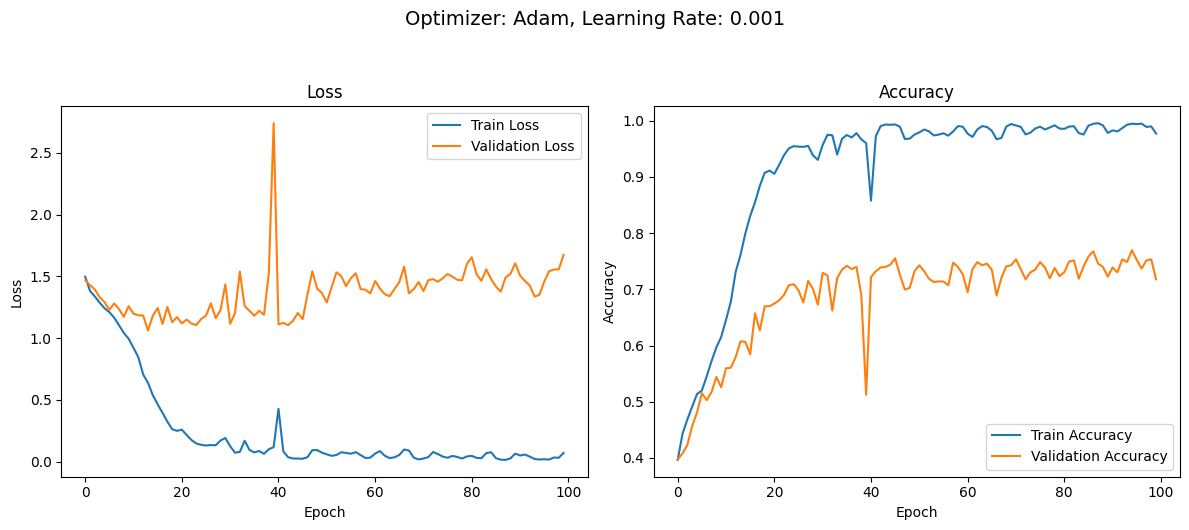


Training with Optimizer: SGD, Learning Rate: 0.01


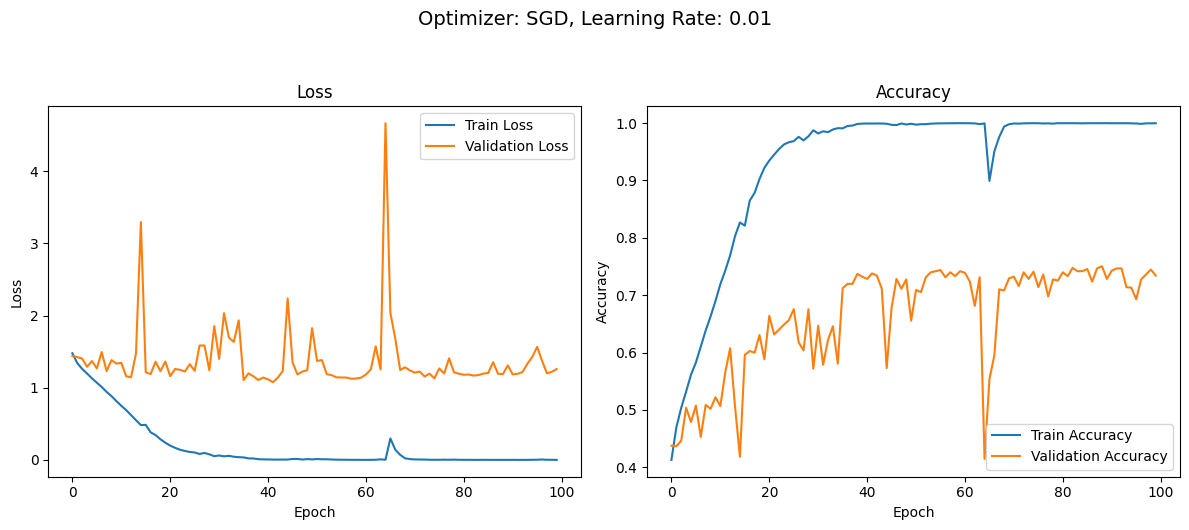


Training with Optimizer: SGD, Learning Rate: 0.001


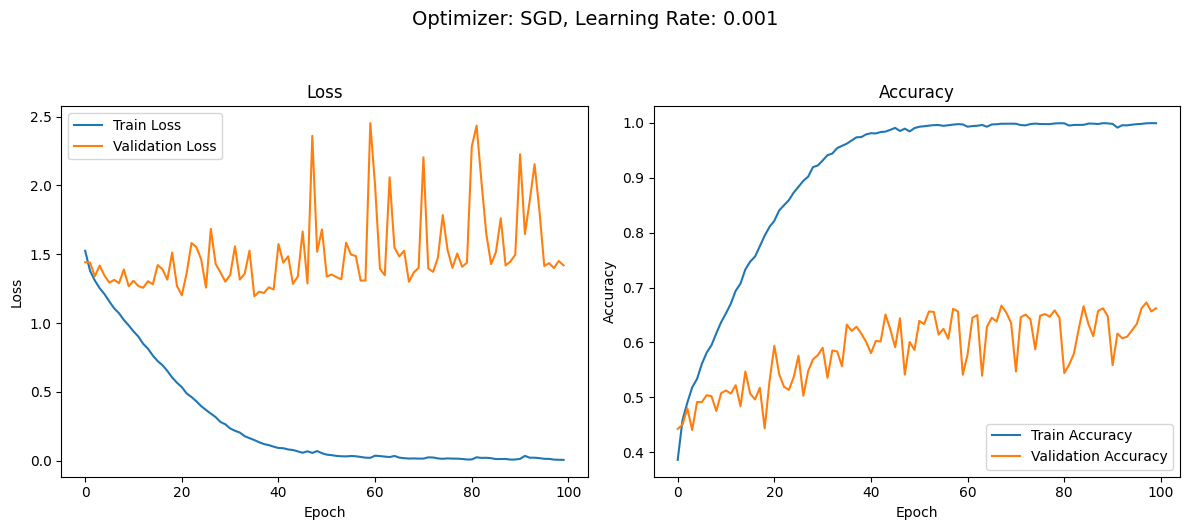


Training with Optimizer: RMSprop, Learning Rate: 0.01


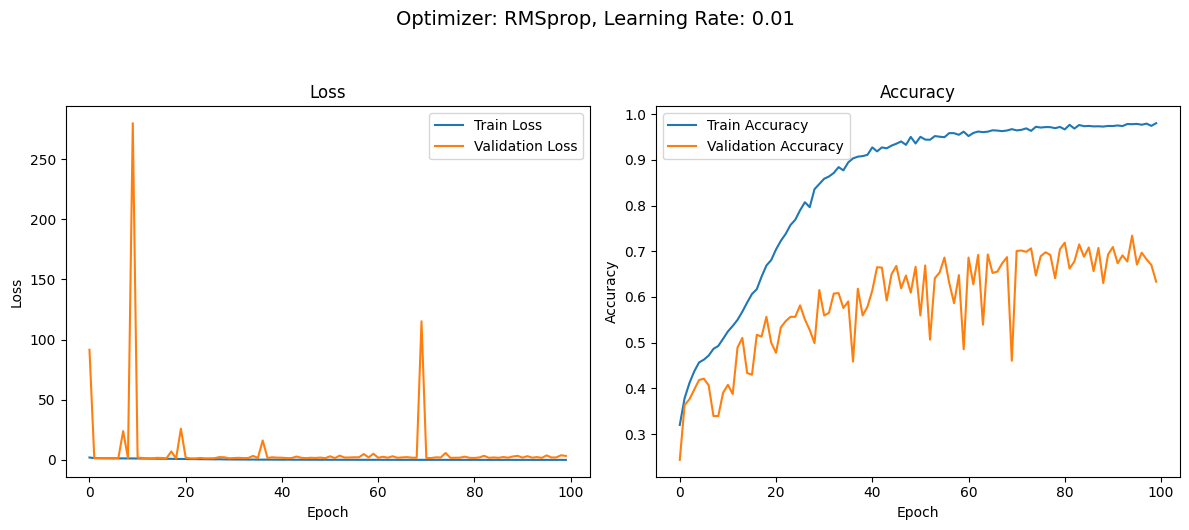


Training with Optimizer: RMSprop, Learning Rate: 0.001


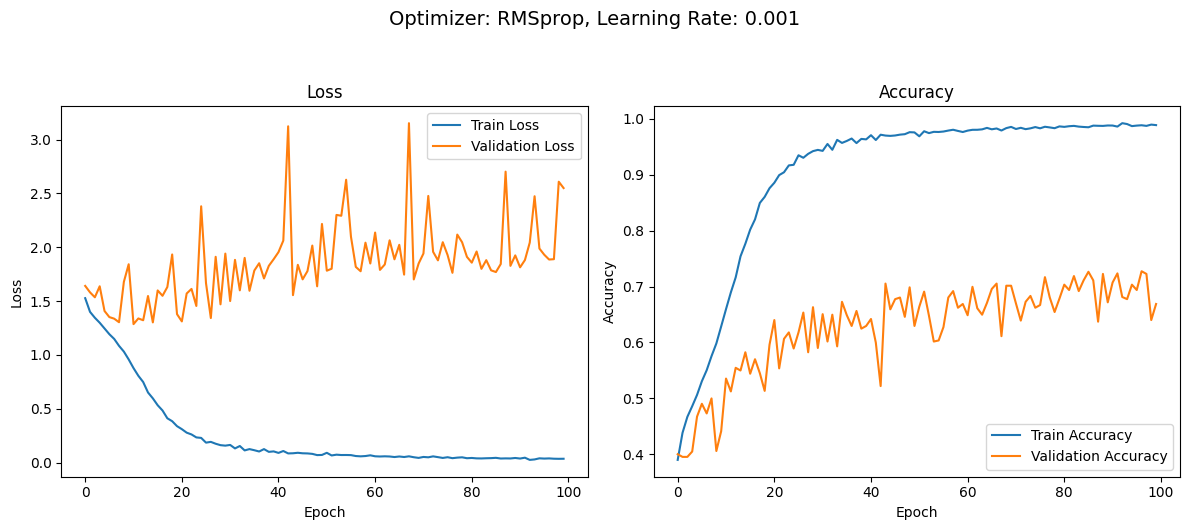

In [15]:
optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}
learning_rates = [0.01, 0.001]

combo_best_acc = 0
best_val_accuracy = 0.0
best_combination = ()

for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
        print(f"\nTraining with Optimizer: {opt_name}, Learning Rate: {lr}")

        model = CNN1D()
        model.to(device)
        optimizer = opt_class(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_losses.clear()
        val_losses.clear()
        train_accuracies.clear()
        val_accuracies.clear()

        combo_best_acc = train(model, train_loader, val_loader, optimizer, criterion, combo_best_acc, num_epochs=100)

        plot_title = f"Optimizer: {opt_name}, Learning Rate: {lr}"
        plot_metrics(title=plot_title)

        if combo_best_acc > best_val_accuracy:
            best_val_accuracy = combo_best_acc
            best_combination = (opt_name, lr)

# **Best Combination**

In [20]:
print(f"Optimizer: {best_combination[0]}, Learning Rate: {best_combination[1]}")

Optimizer: Adam, Learning Rate: 0.001


# **Evaluate Model on Validation Data**

In [17]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device, categories):
    model.load_state_dict(torch.load('best_model.pt'))
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            true_labels = torch.argmax(y_batch, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.7697
F1 Score (Micro): 0.7697
F1 Score (Macro): 0.7686
F1 Score (Weighted): 0.7692


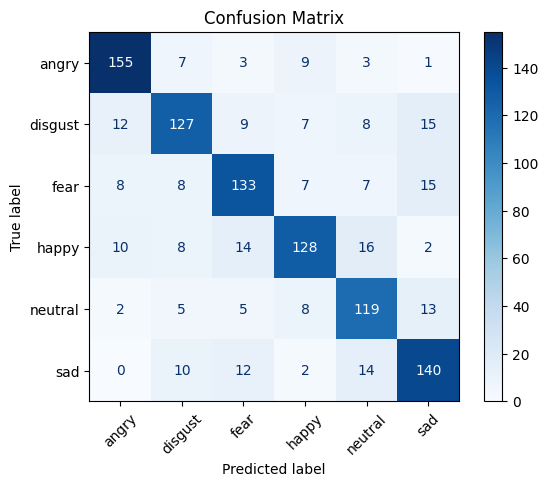

In [18]:
evaluate_model(model, val_loader, device, ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])

# **Evaluate Model On Test Data**

Accuracy: 0.7559
F1 Score (Micro): 0.7559
F1 Score (Macro): 0.7557
F1 Score (Weighted): 0.7557


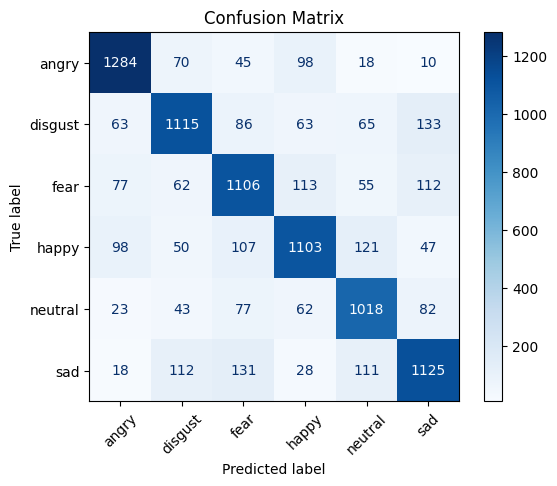

In [19]:
evaluate_model(model, test_loader, device, ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'])